In [1]:
from scipy.spatial import distance
from tqdm.notebook import tqdm
import datetime
import dpkt
import numpy as np
import matplotlib.pyplot as plt
import os
import open3d as op3 
import pandas as pd
import time
from scipy.sparse.csgraph import connected_components
from open3d import JVisualizer
from BfTableGenerator import RansacCollector
from matplotlib import cm
from sklearn.cluster._dbscan_inner import dbscan_inner
from numpy.lib.stride_tricks import sliding_window_view
from DDBSCAN import Raster_DBSCAN
from scipy import ndimage 
import cv2
from scipy.optimize import linear_sum_assignment

theta_raw = np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                            [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                            [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                            [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                            [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                            [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                            [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                            [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                            ])[:,0]
theta = np.sort(theta_raw)
azimuths = np.arange(0,360,0.2)

In [2]:
np.set_printoptions(suppress=True)

In [312]:
# os.chdir(r'/Users/czhui960/Documents/Lidar/RawLidarData/FrameSamplingTest/')
# frame_set = np.arange(0,5000,1).astype('int')
# collector = RansacCollector(pcap_path=r'./2020-7-27-10-30-0.pcap',frames_set = frame_set)
os.chdir(r'/Users/czhui960/Documents/Lidar/RawLidarData/US395/')
frame_set = np.arange(0,5000,1).astype('int')
collector = RansacCollector(pcap_path=r'./US395.pcap',frames_set = frame_set)
collector.gen_tdmap()
collector.gen_thredmap(d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1,inuse_frame = frame_set)
# d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1 FrameSampling


  0%|          | 2/5000 [00:00<04:29, 18.58it/s]

Loading pcap...


  0%|          | 0/32 [00:00<?, ?it/s]

Generating Threshold Map


100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


In [318]:
collector.gen_tdmap()

  0%|          | 2/5000 [00:00<06:09, 13.54it/s]

Loading pcap...


100%|██████████| 5000/5000 [03:40<00:00, 22.65it/s]


In [313]:
Thred_map = collector.thred_map
db = Raster_DBSCAN(window_size=(5,13),eps = 1.5, min_samples= 16,Td_map_szie=Thred_map.shape)

In [314]:
Td_maps = []
Labeling_maps = []
Time_consumings = []
for i in tqdm(range(2000)):
    ti = time.time()
    Td_map = collector.td_maps[i].copy()
    Foreground_map = (Td_map < Thred_map)&(Td_map != 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    Td_maps.append(Td_map)
    Labeling_maps.append(Labeling_map)
    Time_consumings.append((time.time() - ti)*1000)

# Kalman Filter 

In [6]:
def convert_point_cloud(Td_map, Labeling_map): 
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):

        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i])

        # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])

        Labels.append(Labeling_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    return XYZ, Labels

In [7]:
def get_params_from_detection_points(Td_map,Labeling_map,Label):
    
    XYZ,Labels = convert_point_cloud(Td_map,Labeling_map)
    pcd = op3.geometry.PointCloud()
    pcd.points = op3.utility.Vector3dVector(XYZ[Labels == Label])
    bbox = pcd.get_axis_aligned_bounding_box()
    # x,y,length,width,height 
    xylwh = np.concatenate([bbox.get_center()[:2],bbox.get_max_bound() - bbox.get_min_bound()])
    return xylwh



In [8]:
def extract_xylwh_by_frame(Labeling_map,Td_map):
    
    XYZ,Labels = convert_point_cloud(Td_map,Labeling_map)
    if -1 in Labels:
        unique_id = np.unique(Labels)[1:]
    else:
        unique_id = np.unique(Labels)
    xylwh_set = []  
    for l in unique_id:
        xylwh = get_params_from_detection_points(Td_map,Labeling_map,l)
        xylwh_set.append(xylwh)
    
    return np.array(xylwh_set),unique_id

In [9]:
def extract_mea_state_vec(xylwh_set):
    return xylwh_set.reshape((-1,xylwh_set.shape[1],1))

In [10]:
def state_predict(A,Q,state,P):
    """
    state: s_k-1, (n x 10 x 1)
    Cov: P_k-1 (n x 10 x 10)
    """
    state_ = np.matmul(A,state)
    P_ = np.matmul(np.matmul(A,P),A.transpose()) + Q
    return state_,P_

def state_update(A,H,state_,P_,R,mea):
    """
    mea: m_k (m x 5 x 1)
    
    """
    K = np.matmul(np.matmul(P_,H.transpose()),np.linalg.inv(np.matmul(np.matmul(H,P_),H.transpose()) + R))
    P = np.matmul((np.eye(A.shape[0]) - np.matmul(K,H)),P_)
    residual = mea - np.matmul(H,state_) # n x 5 x 1
    state = state_ + np.matmul(K,residual)
    
    return state, P 

In [11]:
def cal_IOU(s_,m):
    
    sx1,sy1,sx2,sy2 = s_[0] - s_[2]/2, s_[1] - s_[3]/2, s_[0] + s_[2]/2, s_[1] + s_[3]/2
    mx1,my1,mx2,my2 = m[0] - m[2]/2, m[1] - m[3]/2, m[0] + m[2]/2, m[1] + m[3]/2

    area1 = (sx2-sx1)*(sy2-sy1)
    area2 = (mx2-mx1)*(my2-my1)
    x1 = max(sx1, mx1)
    x2 = min(sx2, mx2)
    y1 = max(sy1, my1)
    y2 = min(sy2, my2)

    if x1 >= x2 or y1 >= y2:
        return 0
    else:
        inter_area = (x2-x1)*(y2-y1)
        IOU = inter_area/(area1 + area2 - inter_area)
        return IOU

In [297]:
def get_affinity_mat(state,state_,P_,mea,R):
    State_affinity = np.zeros((state_.shape[0],mea.shape[0]))
    for i,s_ in enumerate(state_):
        v_ = s_.copy().flatten()
        v = state[i].copy().flatten()
        VI_spatial = P_[i][:2,:2].copy()
        VI_embed = P_[i][2:5,2:5].copy()
        v_sptial = v[:2]
        v_embed = v[2:5]
        
        for j,m in enumerate(mea):
            u = m.copy().flatten()
            d = np.sqrt(np.sum((v[:2] - u[:2])**2))
#             State_affinity[i][j] = multivariate_normal.pdf(u.flatten(),v_.flatten(),VI)
#             State_affinity[i][j] = distance.mahalanobis(u.flatten(),v_.flatten(),np.linalg.inv(VI))
            if d < 7 :
                simi_spatial = distance.mahalanobis(u[:2],v_sptial,VI_spatial)
                simi_embed = distance.mahalanobis(u[2:],v_embed,VI_embed)
                State_affinity[i][j] = 0.9*simi_spatial + 0.1*simi_embed
            else:
                State_affinity[i][j] = 1e3
            
    return State_affinity

In [13]:
def create_new_detection(Tracking_pool,Global_id,P_init,state_init,label_init,mea_init,start_frame):
    
    new_detection = detected_obj()
    new_detection.glb_id = Global_id
    new_detection.P = P_init
    new_detection.state = state_init
    new_detection.label_seq.append(label_init)
    new_detection.start_frame = start_frame
    new_detection.mea_seq.append(mea_init)
    new_detection.post_seq.append(state_init)
    Tracking_pool[Global_id] = new_detection
    


In [14]:
def process_fails(Tracking_pool,Off_tracking_pool,glb_id,state_cur_,P_cur_):
    if Tracking_pool[glb_id].missing_count > missing_thred:
        Off_tracking_pool[glb_id] = Tracking_pool.pop(glb_id)
    else:
        Tracking_pool[glb_id].missing_count += 1
        Tracking_pool[glb_id].state = state_cur_
        Tracking_pool[glb_id].P = P_cur_
        Tracking_pool[glb_id].label_seq.append(-1)
        Tracking_pool[glb_id].mea_seq.append(-1)
        Tracking_pool[glb_id].post_seq.append(-1)

In [15]:
def associate_detections(Tracking_pool,glb_id,state,P,next_label,mea_next):
    
    Tracking_pool[glb_id].state = state
    Tracking_pool[glb_id].P = P
    Tracking_pool[glb_id].label_seq.append(next_label)
    Tracking_pool[glb_id].mea_seq.append(mea_next)
    Tracking_pool[glb_id].post_seq.append(state)
    Tracking_pool[glb_id].missing_count = 0

In [16]:
class detected_obj():
    def __init__(self):
        self.glb_id = None
        self.start_frame = None
        self.missing_count = 0 # frame count of out of detection
        self.P = None
        self.state = None 
        self.label_seq = [] # represented labels at each frame 
        self.mea_seq = []
        self.post_seq = []

        

In [228]:
def tracking(Q,A,H,R,P_em,missing_thred):
    afs = []
    # Initialization 

    """ 
    Temp for Tracking
    state_num: dim of presumed state space 
    """
    Frame_ind = 0
    Tracking_pool = {}
    Off_tracking_pool = {}
    Global_id = 0 
    missing_thred = missing_thred
    

    xylwh_init,unique_label_init = extract_xylwh_by_frame(Labeling_maps[Frame_ind],Td_maps[Frame_ind])
    
    mea_init = extract_mea_state_vec(xylwh_init)
    # m: n x 5 x 1
    
    state_init = np.concatenate([mea_init,np.zeros((mea_init.shape[0],7)).reshape(mea_init.shape[0],7,-1)],axis = 1)
    
    P_init = np.full((xylwh_init.shape[0],A.shape[0],A.shape[0]),P_em)

    for i,label in enumerate(unique_label_init):
        create_new_detection(Tracking_pool,Global_id,P_init[i],state_init[i],label,mea_init[i],Frame_ind)
        Global_id += 1
        
    Frame_ind += 1 
    """ Loop Start"""


    state_cur,P_cur,glb_id_cur = state_init,P_init,unique_label_init 

    # MOT start, given the prediction from last frame, set up cost func to associate IDs between current and next frame 
    while Frame_ind < 2000:
        """
        Extract Matrix P and State of each tracklet in Current Tracking Pool
        """
        glb_ids,P_cur,state_cur = [],[],[]
        for glb_id in Tracking_pool.keys():
            glb_ids.append(glb_id)
            P_cur.append(Tracking_pool[glb_id].P)
            state_cur.append(Tracking_pool[glb_id].state)
            
        glb_ids,P_cur,state_cur = np.array(glb_ids),np.array(P_cur),np.array(state_cur)

        state_cur_,P_cur_ = state_predict(A,Q,state_cur,P_cur) # predict next state 

        xylwh_next,unique_lebel_next = extract_xylwh_by_frame(Labeling_maps[Frame_ind],Td_maps[Frame_ind]) # read observation at next frame 
        mea_next = extract_mea_state_vec(xylwh_next)
        State_affinity = get_affinity_mat(state_cur,state_cur_,P_cur_,mea_next,R)
        
        afs.append(State_affinity)
        associated_ind_glb,associated_ind_label = linear_sum_assignment(State_affinity)
        associated_ind_glb_,associated_ind_label_ = [],[]
        for i,ass_id in enumerate(associated_ind_glb):
            if State_affinity[ass_id,associated_ind_label[i]] < 1:
                associated_ind_glb_.append(ass_id)
                associated_ind_label_.append(associated_ind_label[i])
        associated_ind_glb,associated_ind_label = np.array(associated_ind_glb_),np.array(associated_ind_label_)
        
        """
        Failed tracking and new detections
        """
        # in a but not in b
        failed_tracked_ind = np.setdiff1d(np.arange(len(glb_ids)),associated_ind_glb) 
        
        if len(failed_tracked_ind) > 0:
            for fid in failed_tracked_ind:
                process_fails(Tracking_pool,Off_tracking_pool,glb_ids[fid],state_cur_[fid],P_cur_[fid])

        new_detection_ind = np.setdiff1d(np.arange(len(unique_lebel_next)),associated_ind_label)
        if len(new_detection_ind) > 0:
            for n_id in new_detection_ind:
                state_init = np.concatenate([mea_next[n_id], np.zeros((7,1))])
                create_new_detection(Tracking_pool,Global_id,P_em,state_init,unique_lebel_next[n_id],mea_next[n_id],Frame_ind)
                Global_id += 1
            
        if len(associated_ind_glb) != 0:
            state,P = state_update(A,H,state_cur_[associated_ind_glb],P_cur_[associated_ind_glb],R,mea_next[associated_ind_label])
            glb_ids = glb_ids[associated_ind_glb]
            mea_next = mea_next[associated_ind_label]
            unique_lebel_next = unique_lebel_next[associated_ind_label]
            
            """
            Associate detections 
            """
            for i,glb_id in enumerate(glb_ids):

                associate_detections(Tracking_pool,glb_id,state[i],P[i],
                                     unique_lebel_next[i],
                                     mea_next[i])
            
        Frame_ind += 1 
    """
    Release all tracking obj into off tracking pool
    """
    release_ids = [glb_id for glb_id in Tracking_pool.keys()]
    for r_id in release_ids:
        Off_tracking_pool[r_id] = Tracking_pool.pop(r_id)
    return Off_tracking_pool,afs

In [315]:
# two-order dynamic model
A = np.array( # x,y,l,w,h,,x',y',l',w',h',x'',y''
    [[1,0,0,0,0,1,0,0,0,0,.5, 0],
     [0,1,0,0,0,0,1,0,0,0, 0,.5],
     [0,0,1,0,0,0,0,1,0,0, 0, 0],
     [0,0,0,1,0,0,0,0,1,0, 0, 0],
     [0,0,0,0,1,0,0,0,0,1, 0, 0],
     [0,0,0,0,0,1,0,0,0,0, 1, 0],
     [0,0,0,0,0,0,1,0,0,0, 0, 1],
     [0,0,0,0,0,0,0,1,0,0, 0, 0],
     [0,0,0,0,0,0,0,0,1,0, 0, 0],
     [0,0,0,0,0,0,0,0,0,1, 0, 0],
     [0,0,0,0,0,0,0,0,0,0, 1, 0],
     [0,0,0,0,0,0,0,0,0,0, 0, 1]]
)
Q = np.diag([1,1,1,1,1,1,1,1,1,1,1,1])*0.01
H = np.array([[1,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0,0,0]])
R = np.diag([10,10,0.1,0.1,0.1])
P = np.diag([1,1,1,1,1,1,1,1,1,1,1,1])
missing_thred = 7
Off_tracking_pool,af = tracking(Q,A,H,R,P,missing_thred)
keys = [key for key in Off_tracking_pool.keys()]
lengths = [len(Off_tracking_pool[key].mea_seq) for key in Off_tracking_pool.keys()]
mea_list = [Off_tracking_pool[key].mea_seq for key in Off_tracking_pool.keys() ]
mea_list = [[m for m in mea if type(m) != int] for mea in mea_list]
post_list = [Off_tracking_pool[key].post_seq for key in Off_tracking_pool.keys() ]
post_list = [[p for p in pos if type(p) != int] for pos in post_list]
print(len(lengths),np.argsort(lengths))

979 [978 977 150 579 583 584 589 603 610 617 620 633 640 127 659 117 114 113
 815 806 804 800 795 757 566 755 750  94 743  96 704 694  90 557 535 522
 272 288 290 296 321 228 331 340 352 354 355 211 378 207 818 206 202 412
 421 450 455 456 457 459 460 462 482 485 490 492 381 819 653 943 860  28
  24 920 927 911 931  19 859 938  16 853  14  68  34 861  11 947 846   9
   4 896   7  67 876 151 916 892 598 594 486 499 907 147 509  32 528 467
  33  31 841 452 464 976 278 293 312 315 342 216 215 365 466 376 403 941
 413 432 447 139 453 182  26  13 891 548 109  59 752  50 855 135 868 658
  51 656 793 852 681 682 673 698 753 708 738 611 836 734 729 858 622  45
 105 824  93 422 431 415  56 742 136 213 945 262 277 282 975 974 292 834
 311  60  66 952 337  64 844 799 781 364 780 322 194 445 443 904 558 652
 156 741 899 872 654 534 894 143 878 494 642 651 167 863 913 677 615 484
 473 733 722 469 922 713 830 606 137 260 881 253 502 919 341 361 399 362
 363 524  65 662 372 410 760 570 898 973 950 83

In [284]:
# two-order dynamic model
A = np.array( # x,y,l,w,h,,x',y',l',w',h',x'',y''
    [[1,0,0,0,0,1,0,0,0,0,.5, 0],
     [0,1,0,0,0,0,1,0,0,0, 0,.5],
     [0,0,1,0,0,0,0,1,0,0, 0, 0],
     [0,0,0,1,0,0,0,0,1,0, 0, 0],
     [0,0,0,0,1,0,0,0,0,1, 0, 0],
     [0,0,0,0,0,1,0,0,0,0, 1, 0],
     [0,0,0,0,0,0,1,0,0,0, 0, 1],
     [0,0,0,0,0,0,0,1,0,0, 0, 0],
     [0,0,0,0,0,0,0,0,1,0, 0, 0],
     [0,0,0,0,0,0,0,0,0,1, 0, 0],
     [0,0,0,0,0,0,0,0,0,0, 1, 0],
     [0,0,0,0,0,0,0,0,0,0, 0, 1]]
)

H = np.array([[1,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0,0,0]])

R = np.diag([11,11,0.1,0.1,0.1])
P = np.diag([1,1,1,1,1,1,1,1,1,1,1,1])
missing_thred = 5

R_variables = [10,15,20,25,30,50,70,100]
P_variables = [1,5,10,20,50]
Q_variables = [0.01,0.1,1]
for r in R_variables:
    for p in P_variables:
        for q in Q_variables:
            Q = np.diag([1,1,1,1,1,1,1,1,1,1,1,1])*q
            R = np.diag([r,r,0.1,0.1,0.1])
            P = np.diag([1,1,1,1,1,1,1,1,1,1,1,1])*P
            Off_tracking_pool,af = tracking(Q,A,H,R,P,missing_thred)
            print(len(Off_tracking_pool),'params:',r,p,q)

283 params: 10 1 0.01
285 params: 10 1 0.1
290 params: 10 1 1
283 params: 10 5 0.01
285 params: 10 5 0.1
290 params: 10 5 1
283 params: 10 10 0.01
285 params: 10 10 0.1
290 params: 10 10 1
283 params: 10 20 0.01
285 params: 10 20 0.1
290 params: 10 20 1
283 params: 10 50 0.01
285 params: 10 50 0.1
290 params: 10 50 1
285 params: 15 1 0.01
287 params: 15 1 0.1
290 params: 15 1 1
285 params: 15 5 0.01
287 params: 15 5 0.1
290 params: 15 5 1
285 params: 15 10 0.01
287 params: 15 10 0.1
290 params: 15 10 1
285 params: 15 20 0.01
287 params: 15 20 0.1
290 params: 15 20 1
285 params: 15 50 0.01
287 params: 15 50 0.1
290 params: 15 50 1
285 params: 20 1 0.01
287 params: 20 1 0.1
291 params: 20 1 1
285 params: 20 5 0.01
287 params: 20 5 0.1
291 params: 20 5 1
285 params: 20 10 0.01
287 params: 20 10 0.1
291 params: 20 10 1
285 params: 20 20 0.01
287 params: 20 20 0.1
291 params: 20 20 1
285 params: 20 50 0.01
287 params: 20 50 0.1
291 params: 20 50 1
287 params: 25 1 0.01
289 params: 25 1 0.1


In [298]:
# two-order dynamic model
A = np.array( # x,y,l,w,h,,x',y',l',w',h',x'',y''
    [[1,0,0,0,0,1,0,0,0,0,.5, 0],
     [0,1,0,0,0,0,1,0,0,0, 0,.5],
     [0,0,1,0,0,0,0,1,0,0, 0, 0],
     [0,0,0,1,0,0,0,0,1,0, 0, 0],
     [0,0,0,0,1,0,0,0,0,1, 0, 0],
     [0,0,0,0,0,1,0,0,0,0, 1, 0],
     [0,0,0,0,0,0,1,0,0,0, 0, 1],
     [0,0,0,0,0,0,0,1,0,0, 0, 0],
     [0,0,0,0,0,0,0,0,1,0, 0, 0],
     [0,0,0,0,0,0,0,0,0,1, 0, 0],
     [0,0,0,0,0,0,0,0,0,0, 1, 0],
     [0,0,0,0,0,0,0,0,0,0, 0, 1]]
)
Q = np.diag([1,1,1,1,1,1,1,1,1,1,1,1])*0.01
H = np.array([[1,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0,0,0]])
R = np.diag([10,10,0.1,0.1,0.1])
P = np.diag([1,1,1,1,1,1,1,1,1,1,1,1])
missing_thred = 7
Off_tracking_pool,af = tracking(Q,A,H,R,P,missing_thred)
keys = [key for key in Off_tracking_pool.keys()]
lengths = [len(Off_tracking_pool[key].mea_seq) for key in Off_tracking_pool.keys()]
mea_list = [Off_tracking_pool[key].mea_seq for key in Off_tracking_pool.keys() ]
mea_list = [[m for m in mea if type(m) != int] for mea in mea_list]
post_list = [Off_tracking_pool[key].post_seq for key in Off_tracking_pool.keys() ]
post_list = [[p for p in pos if type(p) != int] for pos in post_list]
print(len(lengths),np.argsort(lengths))

In [299]:
Off_tracking_pool,af = tracking(Q,A,H,R,P,missing_thred)
keys = [key for key in Off_tracking_pool.keys()]
lengths = [len(Off_tracking_pool[key].mea_seq) for key in Off_tracking_pool.keys()]
mea_list = [Off_tracking_pool[key].mea_seq for key in Off_tracking_pool.keys() ]
mea_list = [[m for m in mea if type(m) != int] for mea in mea_list]
post_list = [Off_tracking_pool[key].post_seq for key in Off_tracking_pool.keys() ]
post_list = [[p for p in pos if type(p) != int] for pos in post_list]
print(len(lengths),np.argsort(lengths))

252 [101 145  25 181 123  30 171 126 132  69 134 164  57  39  41  96 157 154
  97 165 192 121 196   2 232 230 105 226 195 107 211 106 141  15 200  18
  73 237 117  44 110  26 223 222 108  56  66 104  60 159 187 184 179 103
 219  33 163  50 146 135 136  55 166 119 113  10  52 206 168 205 234 227
  17 122 182  32 140 124 131 251 197 111 158  84  54  91   0 167 153 207
 229  34  85 209 250 151 174 249 138  47 149 170 215  64 143 217  36 235
   7 190 156  49 180 100 208   1 213  81 210  20 199 248   9  63  68  78
  80 127 231  94  87  93 212 247 246 204 148  62 109  51  74 233 178 220
 202 130 175 114 216  22 218  19 129  71 120  28 150  59  13 115  12  21
 128 161 225 125 144 236 142 162  92  14  65  67  53 118 176 183 189  31
  58 173 245 169  75 102   3 244 224  89  37  45  90 203  46 155 243 133
  27 185  43   5  35  88  82 112  79 214   4  98 242  61  99 152 241  72
 160  23 240  40 116  29 193  42  70   6  11  76 201 239  48  24 191 137
  16 228 177  38 172 194 221   8  77 198 188 14

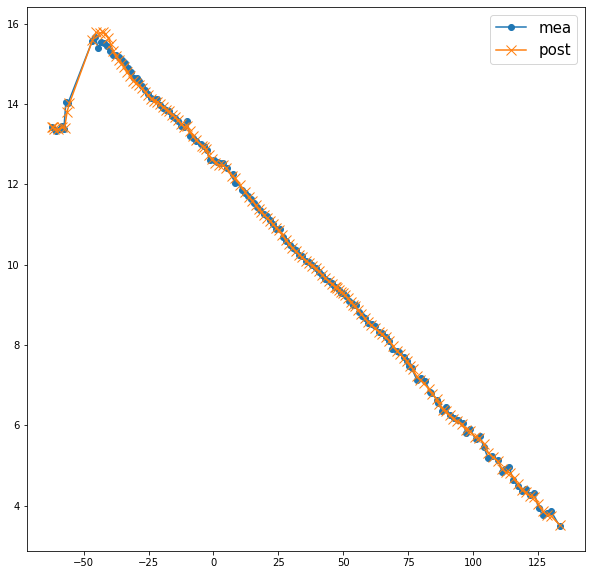

In [316]:
key = 172
mea_sub = np.array(mea_list[key]).reshape(-1,5)
post_sub = np.array(post_list[key]).reshape(-1,12)
plt.figure(figsize=(10,10))
plt.plot(mea_sub[:,0],mea_sub[:,1],label = 'mea',marker = 'o')
plt.plot(post_sub[:,0],post_sub[:,1],label = 'post', marker = 'x',markersize = 10)
plt.legend(fontsize = 15)
plt.show()

In [105]:
from pykalman import KalmanFilter

In [268]:
kf = KalmanFilter(
    A,
    H,
    Q,
    R,
    np.zeros(A.shape[0]),
    np.zeros(R.shape[0]),
    post_list[279][0].flatten(),
    P,
    em_vars=[
      'transition_matrices', 'observation_matrices',
      'transition_covariance', 'observation_covariance',
      'observation_offsets', 'initial_state_mean',
      'initial_state_covariance'
    ]
)
kf = kf.em(X=np.array(mea_list[279]).reshape(-1,5), n_iter=20)

In [269]:
P = kf.initial_state_covariance
R = kf.observation_covariance
Q = kf.transition_covariance

In [272]:
Off_tracking_pool,af = tracking(Q,A,H,R,P,missing_thred)


37.4 s ± 437 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [275]:

# Off_tracking_pool,af = tracking(Q,A,H,R,P,missing_thred)
keys = [key for key in Off_tracking_pool.keys()]
lengths = [len(Off_tracking_pool[key].mea_seq) for key in Off_tracking_pool.keys()]
mea_list = [Off_tracking_pool[key].mea_seq for key in Off_tracking_pool.keys() ]
mea_list = [[m for m in mea if type(m) != int] for mea in mea_list]
post_list = [Off_tracking_pool[key].post_seq for key in Off_tracking_pool.keys() ]
post_list = [[p for p in pos if type(p) != int] for pos in post_list]
np.argsort(lengths)

array([100, 211, 109, 113, 203, 191,  44, 189,  48, 102, 119, 180,  32,
       177, 172,  64, 169, 167, 161, 156, 148,  76, 140,  80, 137, 122,
       215, 192, 231, 232, 104,  20,  27, 249,  17, 228, 236, 222, 268,
       270,   4, 260, 261, 125, 123, 152, 121, 184,  63,  28, 132,  46,
       274, 219, 213, 186,  34, 223, 118, 248,  59, 190,  62,  36, 257,
        57, 151, 153, 128, 242, 193, 134, 199,  19, 216, 273, 241, 136,
        25, 265, 160, 147, 138, 278, 126, 291, 179, 197, 207, 146, 176,
       183,  35,  13,  61, 174,  93,  84, 187, 157,   0,  54,  51, 267,
       244, 178, 195,  38, 290, 202,  95, 154, 206,  89, 135,  87, 233,
       163, 246,   3,  71,   1, 253, 289, 168, 198, 173, 150, 201,  74,
       120, 288,  56,  67,  70, 255, 164, 275, 204,  40,   9, 226, 185,
       114, 245,   2, 251,  90, 240, 247, 158,  22, 235,  69,  11,  75,
        37, 277,  86, 101, 143, 269, 162, 106, 287, 141,  97, 105, 250,
       286, 285, 124,  58,  82, 272, 107, 117, 212,  94, 258, 23

In [1049]:
test_obj = Off_tracking_pool[127]
np.random.seed(150)
color_map = np.random.random((100,3))
for ind,f in enumerate(range(test_obj.start_frame, test_obj.start_frame + len(test_obj.label_seq))):
    Td_map = Td_maps[f]
    Labeling_map = Labeling_maps[f].copy()
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])
    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    Colors = np.zeros((len(Labels),3))
    if test_obj.label_seq[ind] != -1:
        Colors[Labels == test_obj.label_seq[ind]] = color_map[1]
        
    pcd = op3.geometry.PointCloud()
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    op3.io.write_point_cloud(r'./Output File/PcdSequence'+"/{}.pcd".format(ind), pcd)
#     print(i)

In [317]:
np.random.seed(150)
color_map = np.random.random((100,3))
# color_map = np.concatenate([color_map,np.array([[1,1,1]])])

for f in range(2000):
    Td_map = Td_maps[f]
    Labeling_map = Labeling_maps[f].copy()
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])
    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    Colors = np.zeros((len(Labels),3))
    for key in Off_tracking_pool:
        n = f - Off_tracking_pool[key].start_frame
        if (n >= 0) & (n < len(Off_tracking_pool[key].label_seq)):
            label_cur_frame = Off_tracking_pool[key].label_seq[n]
            if label_cur_frame != -1:
                Colors[Labels == label_cur_frame] = color_map[key%len(color_map)]
                
    pcd = op3.geometry.PointCloud()
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    op3.io.write_point_cloud(r'./Output File/PcdSequence'+"/{}.pcd".format(f), pcd)
        
            

In [1154]:
def visualize(Td_map,Labeling_map):
    np.random.seed(250)
    color_map = np.random.random((100,3))
    color_map = np.concatenate([color_map,np.array([[1,1,1]])])
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Valid_ind =  (td_freq_map[i] != 0)&(td_freq_map[i]<collector.thred_map[i]) # None zero index
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Labeling_map[i][Valid_ind])


    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels).astype('int')
    Colors = []
    for i in range(len(Labels)):
        Colors.append(color_map[Labels[i]])
    Colors = np.array(Colors)
    pcd = op3.geometry.PointCloud()
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    visualizer = JVisualizer()
    visualizer.add_geometry(pcd)
    visualizer.show()

In [1155]:
visualize(Td_maps[1900],Labeling_maps[1900])

JVisualizer with 1 geometries